### DQN Implementation
* Tutorial from deeplizar.com
* https://deeplizard.com/learn/video/PyQNfsGUnQA

Libraries necessary

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

### Set Up Display

In [2]:
# Next, we import IPython’s display module to aid us in plotting images to the screen later.
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

### DQN Class
We define our DQN as a class that extends nn.Module. Our DQN will receive screenshot-like images of the cart and pole environment as input, so to create a DQN object, we’ll require the height and width of the image input that will be coming in to this model.

In [3]:
class DQN(nn.Module):
    def __init__(self,img_height,img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t
        
        

### Experience 
To create experiences, we creating a class called Experience. This class will be used to create instances of Experience objects that will get stored in and sampled from replay memory later.

As you can see, we’re creating this class by calling namedtuple(), which is a Python function for creating tuples with named fields.

In [4]:
Experience = namedtuple('Experience',('state', 'action', 'next_state', 'reward'))

Let’s show a quick example of an Experience object.

We’ll set e equal to an instance of the Experience class and pass in the parameters 2, 3, 1, 4. Given the way we set up the Experience class, 2 will be the state of experience e, 3 will be the action, 1 will be the next_state, and 4 will be the reward.

In [5]:
e = Experience(2,3,1,4) 
e

Experience(state=2, action=3, next_state=1, reward=4)

### Replay Memory
Now that we have our Experience class, let’s define our ReplayMemory class, which is where these experiences will be stored.

Recall that replay memory will have some set capacity. This capacity is the only parameter that needs to be specified when creating a ReplayMemory object.

In [6]:
class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    # Store experiences in replay memory as they occur
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    # Returns a random sample of experiences
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # Returns a boolean to tell us whether or not we can sample from memory. 
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size
    
    

### Epsilon Greedy Strategy
To get a balance of exploration and exploitation, we use what we previously introduced as an epsilon greedy strategy. With this strategy, we define an exploration rate called epsilon that we initially set to . This exploration rate is the probability that our agent will explore the environment rather than exploit it. With epsilon equal to ,1 it is 100 percent certain that the agent will start out by exploring the environment.

As the agent learns more about the environment, though, epsilon will decay by some decay rate that we set so that the likelihood of exploration becomes less and less probable as the agent learns more and more about the environment

In [7]:
class EpsilonGreedyStrategy():
    
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    # Our agent is going to be able to use the exploration rate to determine how it should select it’s actions,
    # either by exploring or exploiting the environment.
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)
        
    

### Reinforcement Learning Agent


In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device # device will be the device that we tell PyTorch to use for tensor calculations, i.e. a CPU or GPU.
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore          
        else:
            # We’re specifying with torch.no_grad() before we pass data to our policy_net to turn off gradient tracking 
            # since we’re currently using the model for inference and not training.
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit    

We’re specifying with torch.no_grad() before we pass data to our policy_net to turn off gradient tracking since we’re currently using the model for inference and not training.

During training PyTorch keeps track of all the forward pass calculations that happen within the network. It needs to do this so that it can know how to apply backpropagation later. Since we’re only using the model for inference at the moment, we’re telling PyTorch not to keep track of any forward pass calculations.

### Environment Manager
This class will manage our cart and pole environment. It will wrap several of gym’s environment capabilities, and it will also give us some added functionality, like image preprocessing, for the environment images that will be given to our network as input.

Notice that we’re calling item() on the action we’re passing to step(). This is because the action that will be passed to this function in our main program will be a tensor. We’ll be consistently working with tensors throughout the main program. item() just returns the value of this tensor as a standard Python number, which is what step() expects.

Our take_action() function then returns the reward wrapped in this PyTorch tensor. We’re processing the reward in this way, by wrapping it in a tensor, to put it in the format that will be needed later on in our main program.

So, we have a tensor coming into the function, and a tensor coming out of it. This is how we keep the data type consistent in our main program. Here, we can see where the device comes into play, as we’re setting the device of this tensor to be the device that was passed in to the CartPoleEnvManager.

### Starting An Episode
Next, we have this function just_starting() that returns True when the current_screen is None and returns False otherwise.

Remember, current_screen is set to None in the class constructor and also gets set to None when the environment is reset after ending an episode. So, if current_screen is None, that means we are at the starting state of an episode and haven’t yet rendered an initial observation from the environment.

### Getting The State Of The Environment
Next we define the function get_state(). The point of this function is to return the current state of the environment in the form of a processed image of the screen. Remember, a deep Q-network takes states of the environment as input, and we previously mentioned that for our environment, states would be represented using screenshot-like images.

Actually, note that we will represent a single state in the environment as the difference between the current screen and the previous screen. This will allow the agent to take the velocity of the pole into account from one single image. So, a single state will be represented as a processed image of the difference between two consecutive screens. We’ll see in a moment what type of processing is being done.

We have two conditions we’re checking for in this function.

We check first to see if we are just starting or if we’re done with the episode. Remember, if we’re just starting, then the initial screen has not yet been rendered from the initial observation in the environment. If done == True, then that means the last action taken by the agent ended the episode.

We said that states would be represented as the difference between the last two screens. Well, when we’re at the start of a new episode, there is no last screen to compare to the current screen. So, we’re going to represent our starting state with a fully black screen. The fact we’re doing this will make more sense once we see some visual example of states in a few minutes.

When we’re in the next state that occurs after an agent has taken an action that ended the episode, we’ll also represent this state with a fully black screen as well.

We do this by first calling get_processed_screen(), which returns the processed screen from the environment and assigns this result to the current screen. We then create a fully black screen of the same shape as the current_screen using torch.zeros_like(). We’ll explore the get_processed_screen() function more in a moment.

If we’re not just starting an episode, and we’re not ending it either, then we’re somewhere in the middle of an episode.

In this case we’ll take the difference between the current screen and the last screen and return this result.

In the code above, s1 stands for screen1 and is set to the current_screen. s2 stands for screen2 and is set to the result of a new call to get_processed_screen(). We then update our current_screen to the value of s2. So now, s2 is our current_screen, and s1 is our previous screen, so we return the difference of these two screens to represent a single state.

### Processing The Screen Image
Now, we’ll move on to the get_processed_screen() function we’ve been referencing.
This function first renders the environment as an RGB array using the render() function and then transposes this array into the order of channels by height by width, which is what our PyTorch DQN will expect.

This result is then cropped by passing it to the crop_screen() function, which we’ll cover next. We then pass the cropped screen to the function transform_screen_data(), again, which we’ll cover in a moment, which just does some final data conversion and rescaling to the cropped image.

This transposed, cropped, and transformed version of the original screen returned by gym is what is returned by get_processed_screen().

### Crop Screen Image
The crop_screen() function accepts a screen and will return a cropped version of it. We first get the height of the screen that was passed in, and then we strip off the top and bottom of the screen.

We’ll see an example of a screen both before and after it’s been processed in a moment, and there you’ll see how there is a lot of plain white space at the top and bottom of the cart and pole environment, so we’re removing this empty space here.

We set top equal to the value that corresponds to 40% of the screen_height. Similarly, we set bottom equal to the value that corresponds to 80% of the screen_height.

With these top and bottom values, we then take a slice of the screen starting from the top value down to the bottom value so that we’ve essentially stripped off the top 40% of the original screen and the bottom 20%.

### Convert And Rescale Screen Image Data
Our last image processing function is transform_screen_data(). This function accepts a screen.
We first pass this screen to the numpy ascontiguousarray() function, which returns a contiguous array of the same shape and content as screen, meaning that all the values of this array will be stored sequentially next to each other in memory.

We’re also converting the individual pixel values into type float32 and rescaling all the values by dividing them each by 255. This is a common rescaling process that occurs during image processing for neural network input.

We then convert this array to a PyTorch tensor.

We then use torchvision’s Compose class to chain together several image transformations. We’ll call this compose resize. So, when a tensor is passed to resize, it will first be converted to a PIL image, then it will be resized to a 40 x 90 image. The PIL image is then transformed to a tensor.

So, we pass our screen from above to resize and then add an extra batch dimension to the tensor by calling unsqueeze(). This result is then what is returned by the transform_screen_data() function.

In [9]:
class CartPoleEnvManager():
    
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
        
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    # These functions return the height and width of a processed screen by first 
    # getting a processed screen from the get_processed_screen()
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    # Processing The Screen Image
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

### Example Screens
Alright, we’re now finished up with the our CartPoleEnvManager class. Let’s now take a look visually at the results of all the image processing that we went over from this class.

#### Non-Processed Screen

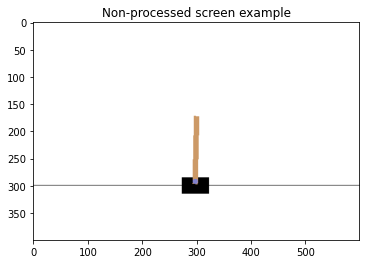

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

### Processed Screen

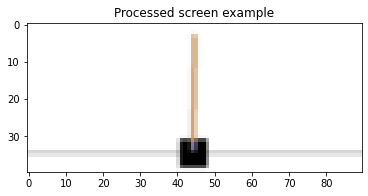

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

####  Starting State

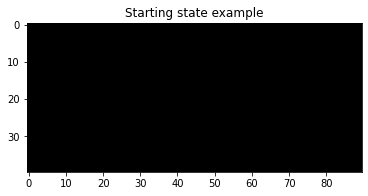

In [12]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

#### Non-Starting State
If we want to see what a state looks that is not a starting state, we can take some actions in the environment and call get_state() again to get this result.

Since we’re taking the difference between the current screen and the previous screen, most pixel values will become zero. The only ones that are anything but zero are just the kind of highlight that we’re seeing here which gives us an idea of where are cart and pole were in the previous screen, and where they have moved to now.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


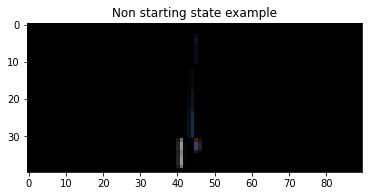

In [13]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

#### Ending State
Lastly, if we want to see the state of the environment after an episode has ended, we specify done = True and call em.get_state() again, and we can see the fully black screen that we’d expect.

So, these states are exactly what will be passed to our DQN as input during training.

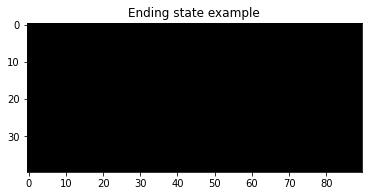

In [14]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

### Utility Functions
Now, we’re going to move on to a couple of quick utility functions we’ll have available to us during training so that we can plot our performance on a chart.

We’re creating this function called plot() that accepts values and a moving average period. This plot will plot the duration of each episode, as well as the 100 episode moving average.

To solve cart and pole, the average reward must be greater than or equal to 195 over 100 consecutive episodes. Recall that our agent gets a reward of +1 for each step it takes that doesn’t end the episode. So, the duration of an episode measured in timesteps is exactly equivalent to the reward for that episode.

In [15]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)

We’ll also want to plot the 100 episode moving average, so we do so by calling the function get_moving_average(), which accepts the moving_average_period and the values for which it will be calculating the moving average from.

In [16]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

Within get_moving_average(), we first transform the values to a PyTorch tensor and then check to see if the length of the values is greater than or equal to the period. We do this because we can’t calculate a moving average of a data set when the data set is not at least as large as the period we want to calculate the moving average for.

For example, if we want to calculate the 100-period moving average of episode durations, then if we’ve only played 90 episodes, a 100-period moving average can’t be calculated.

If this condition is met, then we calculate the moving average by first calling unfold() on the tensor, which returns a tensor that contains all slices with a size equal to the period that was passed in (in our case, that is going to be 100). It does this on the zeroth dimension of the original values tensor.

This gives us a new tensor containing all slices of size 100 across the original value tensor. We then take the mean of each of these slices and flatten the tensor so that now moving_avg is equal to a tensor containing all 100-period averages from the values that were passed in.

We then concatenate this resulting tensor to a tensor of zeros with a size equal to period-1. This is to show that the moving average for the first period-1 values is zero given the explanation we just gave a moment ago. So, if our period is 100, then the first 99 values of the moving_avg tensor will be 0, and then each value afterwards will be the actual calculated 100-period moving average.

We then convert the moving_avg tensor to a numpy array and return this result.

Now, if our initial condition was not met, so that the length of the values array that was initially passed in was not at least the period size, then we just return a numpy array of all zeros with a length equal to the values array that was passed in.

### Training Agent

#### Hyperparameters

In [17]:
batch_size = 256
gamma = 0.999 # Is the discount factor used in the Bellman equation
eps_start = 1 # Starting value of epsilon
eps_end = 0.01 # Ending value of epsilon
eps_decay = 0.001 # Decay rate we’ll use to decay epsilon over time
target_update = 10 # How frequently, in terms of episodes, we’ll update the target network weights with the policy network weights.
memory_size = 100000 # Capacity of the replay memory
lr = 0.001 # Learning rate
num_episodes = 1000 # Number of episodes we want to play

### Essential Objects

In [18]:
# This tells PyTorch to use a GPU if it’s available, otherwise use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# We set up our environment manager
em = CartPoleEnvManager(device)
# We then set our strategy to be an instance of the EpsilonGreedyStrategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

'''
We then define an agent using our Agent class and pass in the required strategy,
number of actions available, and device. 
We then initialize memory to be an instance of ReplayMemory and pass in the capacity using memory_size.
'''
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

# We define both our policy network and target network by creating two instances of our DQN class 
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
'''
We then set the weights and biases in the target_net to be the same as those in the policy_net using 
PyTorch’s state_dict() and load_state_dict() functions. 
We also put the target_net into eval mode, which tells PyTorch that this network is not in 
training mode
'''
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Lastly, we set optimizer equal to the Adam optimizer, which accepts our policy_net.parameters() 
# as those for which we’ll be optimizing, and our defined learning rate lr.
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

### Tensor Processing

In [19]:
# Remember, this is the function that we called to extract all the states, actions, rewards,
# and next_states into their own tensors from a given batch of experiences.

# Extract_tensors() accepts a batch of Experiences and first transposes it into an
# Experience of batches. 

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

### Extract Tensor explanation by examples

In [20]:
#First, let’s create three sample experiences, and put them in a list and see how that looks.
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [21]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Calculating Q-Values

In [22]:
# This is the class that we used to calculate the q-values for the current states using the policy_net,
# and the next states using the target_net.
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    '''
    get_current(). This function accepts a policy_net, states, and actions. 
    When we call this function in our main program, recall that these states and actions are the state-action pairs that were sampled from replay memory. 
    So, the states and actions correspond with each other.
    '''
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    '''
    This function accepts a target_net and next_states.
    Recall that for each next state, we want to obtain the maximum q-value predicted by 
    the target_net among all possible next actions
    '''
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values


### Update To Plot

In [23]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

### Training Loop

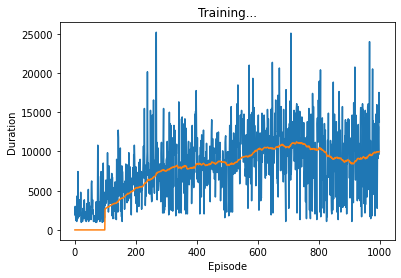

Episode 1000 
 100 episode moving avg: 9994.8


In [24]:
# We’re going to be storing our episode_durations during training in order to plot them
episode_durations = []

''' Main loop '''

# For each episode:
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count(0,120):
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
            
    

    

In [25]:
# 1. Initialize the starting state.
    
    # 2. For each time step:
    
       # 1. Select an action.
            # * Via exploration or exploitation
            
       # 2. Execute selected action in an emulator.
    
       # 3. Observe reward and next state.
        
       # 4. Store experience in replay memory.
    
       # 5. Sample random batch from replay memory.
        
       # 6. Preprocess states from batch.
    
       # 7. Pass batch of preprocessed states to policy network.
        
       # 8. Calculate loss between output Q-values and target Q-values.
    
           # * Requires a pass to the target network for the next state
        
       # 9.Gradient descent updates weights in the policy network to minimize loss.
        
            # * After  time steps, weights in the target network are updated to the weights in the policy network.
